Colab Notebook link - https://colab.research.google.com/drive/1lOF5MGOqcmhu9l-M8JW8FkjeZy-iwIxA

<b> Time series analysis and predictions using different approaches. </b>

Analysing continous temporal data and making future predictions is important in many industries and there are different approaches to handle this task. In this notebook I'm going to use 2 different methods and compare their results with an official next day forecast.
<br><br>
The following models will be used:<br>

<b>Prophet</b> - automatic forecasting tool from Facebook. More information [here](https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/) and [here.](https://youtu.be/pOYAXv15r3A)<br>
<b>LSTM</b> - inputing a sequence of data to predict sequence into the future (many-to-many).
<br><br>

Models will be used to predict hourly electricity demand (in MW) in Switzerland.

Dataset is obtained from https://data.open-power-system-data.org/time_series/2017-07-09
<br><br>
From the dataset description:<br>
"	This data package contains different kinds of timeseries data relevant for power system modelling, namely electricity consumption (load) for 36 European countries as well as wind and solar power generation and capacities and prices for a growing subset of countries. The timeseries become available at different points in time depending on the sources. The data has been downloaded from the sources, resampled and merged in a large CSV file with hourly resolution. Additionally, the data available at a higher resolution (Some renewables in-feed, 15 minutes) is provided in a separate file. All data processing is conducted in python and pandas and has been documented in the Jupyter notebooks linked below."

In [0]:
!pip install --upgrade tensorflow

In [377]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import datetime 
from sklearn.preprocessing import MinMaxScaler


import pandas_profiling as pp
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import losses

from tensorflow.keras.callbacks import ModelCheckpoint
!pip install -q h5py pyyaml

from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose


In [5]:
from google.colab import drive
drive.mount('/gdrive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Load and prepare data 

In [0]:
from pathlib import Path

def get_dataset():

  data_folder = Path("/gdrive/My Drive/Colab Notebooks/EU_electricity")
  data = data_folder / "time_series_60min_singleindex.csv"
  
  df = pd.read_csv(data)
  
  return df

In [22]:
df = get_dataset()
df.head()

utc_timestamp  ... UA_west_load_forecast_entsoe_transparency
0  2004-12-31T23:00:00Z  ...                                       NaN
1  2005-01-01T00:00:00Z  ...                                       NaN
2  2005-01-01T01:00:00Z  ...                                       NaN
3  2005-01-01T02:00:00Z  ...                                       NaN
4  2005-01-01T03:00:00Z  ...                                       NaN

[5 rows x 393 columns]

In [21]:
# Filter columns that contain CH

[s for s in df.columns if "CH_load" in s]

['CH_load_actual_entsoe_power_statistics',
 'CH_load_actual_entsoe_transparency',
 'CH_load_forecast_entsoe_transparency']

In [521]:
# Using CH_load_actual_entsoe_power_statistics column that is "Total load in Switzerland in MW as published on ENTSO-E Data Portal/Power Statistics"

ch_df = df[['cet_cest_timestamp','CH_load_actual_entsoe_power_statistics','CH_load_forecast_entsoe_transparency']].copy()

ch_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125593 entries, 0 to 125592
Data columns (total 3 columns):
cet_cest_timestamp                        125593 non-null object
CH_load_actual_entsoe_power_statistics    115428 non-null float64
CH_load_forecast_entsoe_transparency      37871 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.9+ MB


In [522]:
# change to datetime format, set as an index and remove timezone information

ch_df['cet_cest_timestamp'] = pd.to_datetime(ch_df['cet_cest_timestamp'], format="%Y-%m-%dT%H:%M:%S", utc=True)

ch_df = ch_df.set_index('cet_cest_timestamp')

ch_df = ch_df.tz_convert(None)

ch_df

CH_load_actual_entsoe_power_statistics  CH_load_forecast_entsoe_transparency
cet_cest_timestamp                                                                               
2004-12-31 23:00:00                                     NaN                                   NaN
2005-01-01 00:00:00                                     NaN                                   NaN
2005-01-01 01:00:00                                     NaN                                   NaN
2005-01-01 02:00:00                                     NaN                                   NaN
2005-01-01 03:00:00                                     NaN                                   NaN
...                                                     ...                                   ...
2019-04-30 19:00:00                                     NaN                               6756.19
2019-04-30 20:00:00                                     NaN                               6057.82
2019-04-30 21:00:00                                     NaN                               6069.06
2019-04-30 22:00:00                                     NaN                               5924.70
2019-04-30 23:00:00                                     NaN                                   NaN

[125593 rows x 2 columns]

# Visualise data

Looking at the 2015-2018 period

In [0]:
# Fixing plot size to a timeseries friendly wide format

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["lines.linewidth"] = 0.8

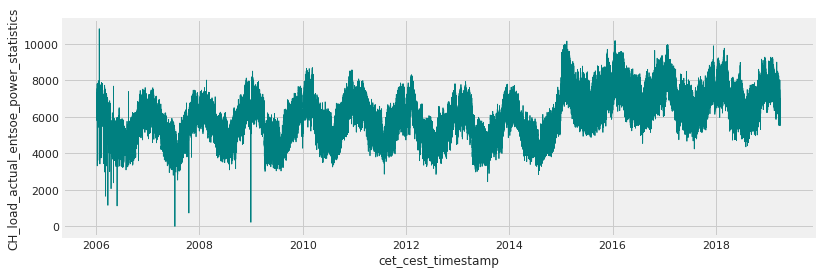

In [0]:
sns.lineplot(y='CH_load_actual_entsoe_power_statistics', x=ch_df.index, data=ch_df, color='teal')
None

Seems there is change in reporting process as there is a jump from 2015. So it is reasonable to use data till 2015 or after.

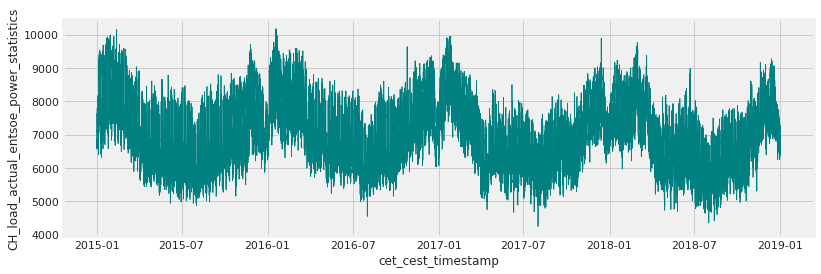

In [0]:
df = ch_df[(ch_df.index.year > 2014) & (ch_df.index.year < 2019)].copy()

sns.lineplot(y=df['CH_load_actual_entsoe_power_statistics'], x=df.index, color='teal')
None

Interesting to see how at the end of the year power demand drops due to Christmas holidays and then goes back up on January.

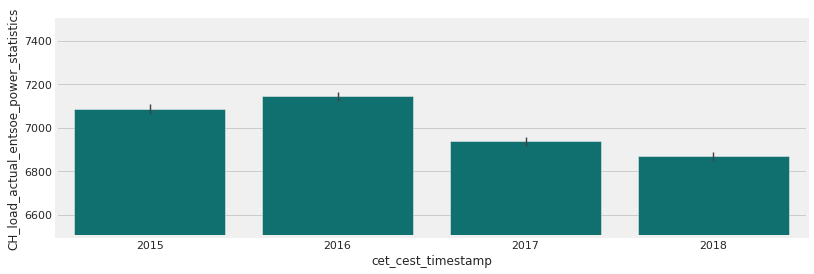

In [0]:
sns.barplot(x=df.index.year, ydf['CH_load_actual_entsoe_power_statistics'], color='teal')
plt.ylim(6500, 7500)
None

There is a tendency for average hourly demand to go down, this is visible in the first plot too, where from 2010 demand peaks and lows are getting lower.

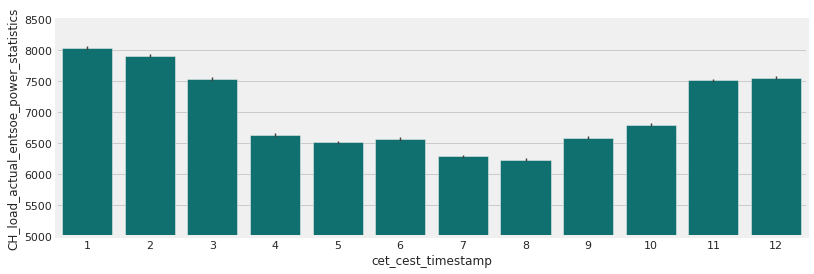

In [0]:
sns.barplot(x=df.index.month, y=df['CH_load_actual_entsoe_power_statistics'], color='teal')
plt.ylim(5000, 8500)
None

Average hourly power consuption is highest in the darkest and coldest months of the year.

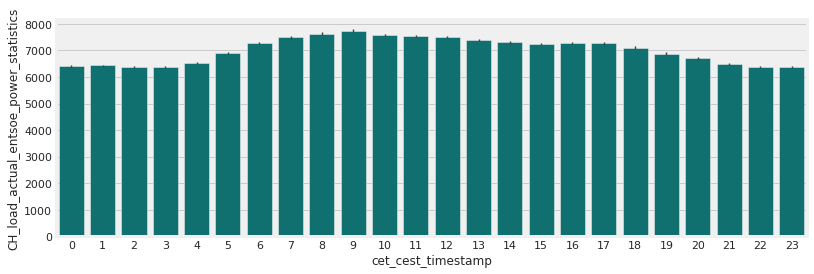

In [0]:
sns.barplot(x=df.index.hour, y=df['CH_load_actual_entsoe_power_statistics'], color='teal')
plt.ylim(5000, 8500)
None

Average hourly power consuption peaks in the morning. Interesting point, that at 5h in the morning consuption is already higher than at 20h in the evening.

# Modeling


Need to cut amount of data, because the predictions will be on a hourly level. Let's pick a random month from year 2017.

In [0]:
month = ch_df[(ch_df.index.year == 2017) & (ch_df.index.month == np.random.randint(1,13,1)[0])]

month = month[['CH_load_actual_entsoe_power_statistics']]


In [0]:
# Splitting the data for training and testing. Lets take first 21 days (24h*21 days) for training and next 7 for testing

train, test = month.iloc[0:504], month.iloc[504:672]

In [622]:
train

CH_load_actual_entsoe_power_statistics
cet_cest_timestamp                                         
2017-10-01 00:00:00                                  5855.0
2017-10-01 01:00:00                                  6078.0
2017-10-01 02:00:00                                  5966.0
2017-10-01 03:00:00                                  6009.0
2017-10-01 04:00:00                                  6005.0
...                                                     ...
2017-10-21 19:00:00                                  5660.0
2017-10-21 20:00:00                                  5577.0
2017-10-21 21:00:00                                  5717.0
2017-10-21 22:00:00                                  5775.0
2017-10-21 23:00:00                                  5882.0

[504 rows x 1 columns]

In [623]:
test

CH_load_actual_entsoe_power_statistics
cet_cest_timestamp                                         
2017-10-22 00:00:00                                  6083.0
2017-10-22 01:00:00                                  6025.0
2017-10-22 02:00:00                                  6051.0
2017-10-22 03:00:00                                  5916.0
2017-10-22 04:00:00                                  5974.0
...                                                     ...
2017-10-28 19:00:00                                  5922.0
2017-10-28 20:00:00                                  6019.0
2017-10-28 21:00:00                                  6385.0
2017-10-28 22:00:00                                  6056.0
2017-10-28 23:00:00                                  6423.0

[168 rows x 1 columns]

Let's take a loot at a decomposed timeseries data

In [0]:
def plots(data):
  pd.plotting.register_matplotlib_converters()
  a = seasonal_decompose(data, model = "add")
  #a.plot();

  plt.figure(figsize = (12,5))
  a.observed.plot()
  plt.title("Observed values");

  plt.figure(figsize = (12,5))
  a.seasonal.plot()
  plt.title("Seasonality component");

  plt.figure(figsize = (12,5))
  a.trend.plot()
  plt.title("Trend component");

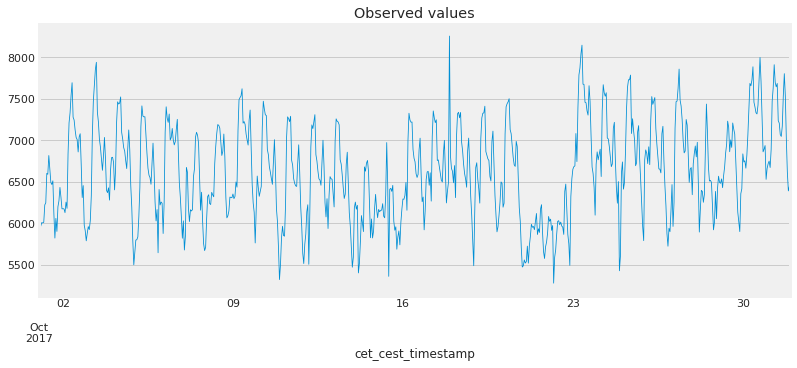

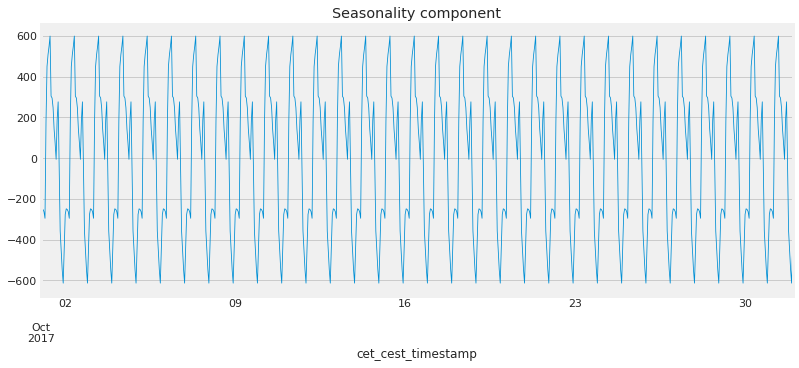

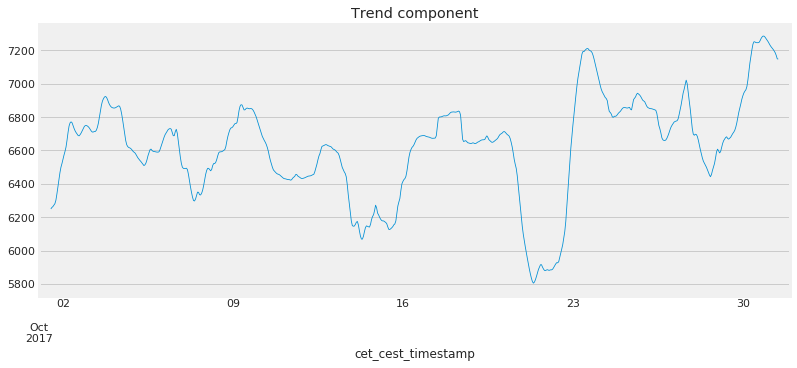

In [625]:
plots(month.CH_load_actual_entsoe_power_statistics)

## Prophet

In [0]:
# Prepare data in Prophet format with DS as a time column and Y as values

prophet_train = train.copy()
prophet_train.reset_index(inplace=True)

In [0]:
prophet_train.rename(columns={"CH_load_actual_entsoe_power_statistics": "y", 'cet_cest_timestamp': "ds" }, inplace=True)

In [628]:
prophet_train

ds       y
0   2017-10-01 00:00:00  5855.0
1   2017-10-01 01:00:00  6078.0
2   2017-10-01 02:00:00  5966.0
3   2017-10-01 03:00:00  6009.0
4   2017-10-01 04:00:00  6005.0
..                  ...     ...
499 2017-10-21 19:00:00  5660.0
500 2017-10-21 20:00:00  5577.0
501 2017-10-21 21:00:00  5717.0
502 2017-10-21 22:00:00  5775.0
503 2017-10-21 23:00:00  5882.0

[504 rows x 2 columns]

In [629]:
m = Prophet(weekly_seasonality=True)
m.fit(prophet_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [630]:
prophecy = m.make_future_dataframe(freq="H", periods=7*24)

predict = m.predict(prophecy)

predict[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds         yhat   yhat_lower   yhat_upper
0   2017-10-01 00:00:00  5769.290060  5366.044779  6174.471061
1   2017-10-01 01:00:00  5792.536096  5401.591767  6185.076814
2   2017-10-01 02:00:00  5757.200016  5363.216049  6170.914789
3   2017-10-01 03:00:00  5788.975123  5403.072176  6197.281135
4   2017-10-01 04:00:00  5976.703284  5578.945399  6350.805516
..                  ...          ...          ...          ...
667 2017-10-28 19:00:00  5729.392198  5289.730076  6176.885841
668 2017-10-28 20:00:00  5492.803773  5041.910570  5922.233268
669 2017-10-28 21:00:00  5377.834471  4941.639075  5793.325884
670 2017-10-28 22:00:00  5435.835150  4979.084422  5848.965465
671 2017-10-28 23:00:00  5594.882393  5183.843145  6044.414516

[672 rows x 4 columns]

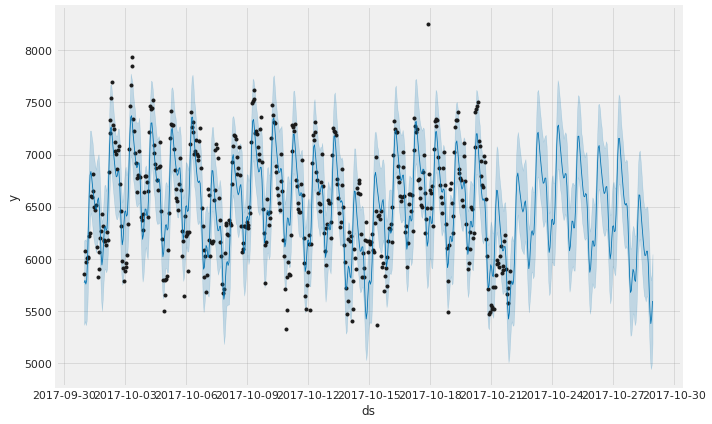

In [631]:
fig1 = m.plot(predict)


In [632]:
# Add prediction to the test DF for later comparison between models

test["prophet"] = predict.yhat[504:672].values

test

CH_load_actual_entsoe_power_statistics      prophet
cet_cest_timestamp                                                      
2017-10-22 00:00:00                                  6083.0  5766.790042
2017-10-22 01:00:00                                  6025.0  5788.465801
2017-10-22 02:00:00                                  6051.0  5751.559442
2017-10-22 03:00:00                                  5916.0  5781.764272
2017-10-22 04:00:00                                  5974.0  5967.922155
...                                                     ...          ...
2017-10-28 19:00:00                                  5922.0  5729.392198
2017-10-28 20:00:00                                  6019.0  5492.803773
2017-10-28 21:00:00                                  6385.0  5377.834471
2017-10-28 22:00:00                                  6056.0  5435.835150
2017-10-28 23:00:00                                  6423.0  5594.882393

[168 rows x 2 columns]

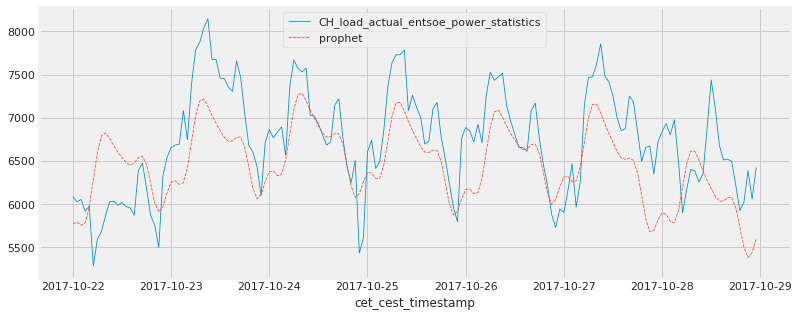

In [633]:
plt.figure(figsize = (12,5))
sns.lineplot(data=test)
None

Depending on a chosen month, results could be pretty accurate with Prophet model without any tuning. <br>
There could be clear issues when a trend in consumption changes, for example when heat/cold wave arrives and model could not anticipate this change in trend.

## LSTM

Here I will explore 2 options:
- Train one model by feeding a sliding window with the last 24h information and predicting 1h into the future.
- Train second model using the same 3 week dataset by feeding 24h worth of information at once to predict next 24h.



### Data preparation

In [0]:
# First - scale the training data

scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(np.array(test.iloc[:,0]).reshape(-1, 1))

In [0]:
# Using generator to prepare data where last 24 records are used to predict 25th.

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

n_input = 24

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [636]:
for number, i in zip(range(3),generator):
  print(i)

(array([[[0.18138425],
        [0.25741562],
        [0.21922946],
        [0.23389021],
        [0.23252642],
        [0.23525401],
        [0.3065121 ],
        [0.31537675],
        [0.43607228],
        [0.43232185],
        [0.50937607],
        [0.45311967],
        [0.39856802],
        [0.39038527],
        [0.40538698],
        [0.27037163],
        [0.17047392],
        [0.25127855],
        [0.19774974],
        [0.29901125],
        [0.32321855],
        [0.3784521 ],
        [0.33822025],
        [0.29048756]]]), array([[0.2908285]]))
(array([[[0.25741562],
        [0.21922946],
        [0.23389021],
        [0.23252642],
        [0.23525401],
        [0.3065121 ],
        [0.31537675],
        [0.43607228],
        [0.43232185],
        [0.50937607],
        [0.45311967],
        [0.39856802],
        [0.39038527],
        [0.40538698],
        [0.27037163],
        [0.17047392],
        [0.25127855],
        [0.19774974],
        [0.29901125],
        [0.32321855],
     

### LSTM model1_1

using rolling window of past 24h data to predict next 1h.

In [0]:
tf.keras.backend.clear_session()

In [638]:
filepath='../gdrive/My Drive/Colab Notebooks/EU_electricity/weights-LSTM1_1-{loss:.3f}.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=True, mode='auto', monitor="loss")
callbacks_list = [cp_callback]

n_input = 24
n_features = train.shape[1]
epochs = 25
steps_per_epoch=24

lstm_model1_1 = Sequential()
lstm_model1_1.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
lstm_model1_1.add(Dense(50, activation='relu'))
lstm_model1_1.add(Dense(1))
lstm_model1_1.compile(optimizer='adam', loss='mse')

lstm_model1_1.fit_generator(generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, callbacks=callbacks_list)



Epoch 1/25
23/24 [===========================>..] - ETA: 0s - loss: 0.1166
Epoch 00001: loss improved from inf to 0.11180, saving model to ../gdrive/My Drive/Colab Notebooks/EU_electricity/weights-LSTM1_1-0.112.hdf5
24/24 [==============================] - 2s 68ms/step - loss: 0.1118
Epoch 2/25
23/24 [===========================>..] - ETA: 0s - loss: 0.0282
Epoch 00002: loss improved from 0.11180 to 0.02701, saving model to ../gdrive/My Drive/Colab Notebooks/EU_electricity/weights-LSTM1_1-0.027.hdf5
24/24 [==============================] - 2s 78ms/step - loss: 0.0270
Epoch 3/25
23/24 [===========================>..] - ETA: 0s - loss: 0.0405
Epoch 00003: loss did not improve from 0.02701
24/24 [==============================] - 2s 63ms/step - loss: 0.0392
Epoch 4/25
23/24 [===========================>..] - ETA: 0s - loss: 0.0257
Epoch 00004: loss did not improve from 0.02701
24/24 [==============================] - 2s 65ms/step - loss: 0.0294
Epoch 5/25
23/24 [==========================

In [0]:
# Function to plot training performance

def training_perf(modelname):
  losses_lstm = modelname.history.history['loss']
  plt.figure(figsize=(12,4))
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.xticks(np.arange(0,epochs,5))
  plt.plot(range(len(losses_lstm)),losses_lstm);


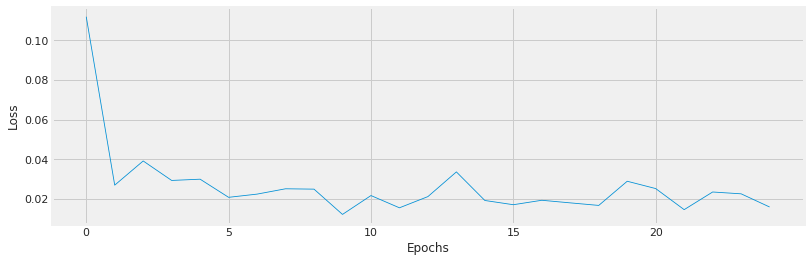

In [640]:
training_perf(lstm_model1_1)

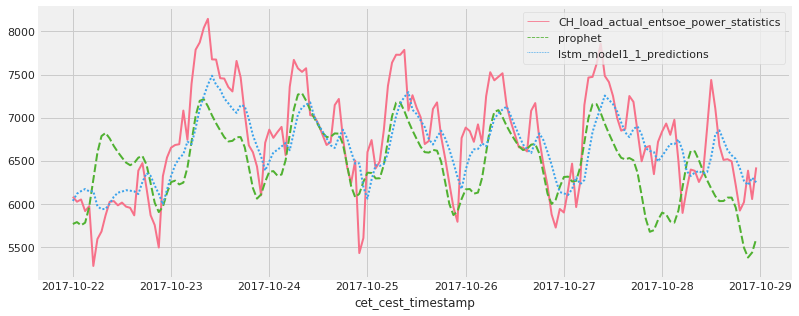

In [641]:
# To make a prediction for the first period in test set, we need to use data 24 hours before test set starts.
# So instead of scaling test set, scale whole month with the same scaler that was used for train set
# and slice the data to my needs.

scaled_month = scaler.transform(month)

# Making a sliding window of 24h data, reshaping the data, predicting for the next hour and save it to the empty list.

lstm_model1_1_predictions_scaled = []

for i in range(0,len(test)):

  test_slice = np.array(scaled_month[480+i:671][:n_input])
  test_slice = test_slice.reshape((1, n_input, n_features))
  lstm_pred = lstm_model1_1.predict(test_slice)[0]
  lstm_model1_1_predictions_scaled.append(lstm_pred)

lstm_model1_1_predictions = scaler.inverse_transform(lstm_model1_1_predictions_scaled)
test['lstm_model1_1_predictions'] = lstm_model1_1_predictions

plt.figure(figsize = (12,5))
sns.lineplot(data=test, palette="husl", lw=2)



For short term prediction LSTM model predicts very well, but this type of forecast is very different from Prophet who does whole week at once. <br>


### LSTM model 1_24

use a window of past 24h data to predict next 24h.

In [0]:
# Reshaping 3 weeks data in to 21 piece with 24 data points
# Splitting to X and y where Day 0 will be used to predict Day 1, Day 1 to Day 2 and etc.

scaled_train_24 = scaled_train.reshape(21,24,1)

X_train_24, y_train_24  = scaled_train_24[:-1], scaled_train_24[1:]

Train on 20 samples
Epoch 1/40
16/20 [=======================>......] - ETA: 0s - loss: 0.2001
Epoch 00001: loss improved from inf to 0.19939, saving model to ../gdrive/My Drive/Colab Notebooks/EU_electricity/weights-LSTM1_24-0.199.hdf5
20/20 [==============================] - 1s 73ms/sample - loss: 0.1994
Epoch 2/40
12/20 [=================>............] - ETA: 0s - loss: 0.1859
Epoch 00002: loss improved from 0.19939 to 0.17315, saving model to ../gdrive/My Drive/Colab Notebooks/EU_electricity/weights-LSTM1_24-0.173.hdf5
20/20 [==============================] - 0s 24ms/sample - loss: 0.1732
Epoch 3/40
16/20 [=======================>......] - ETA: 0s - loss: 0.1405
Epoch 00003: loss improved from 0.17315 to 0.12774, saving model to ../gdrive/My Drive/Colab Notebooks/EU_electricity/weights-LSTM1_24-0.128.hdf5
20/20 [==============================] - 0s 20ms/sample - loss: 0.1277
Epoch 4/40
16/20 [=======================>......] - ETA: 0s - loss: 0.0712
Epoch 00004: loss improved from 0

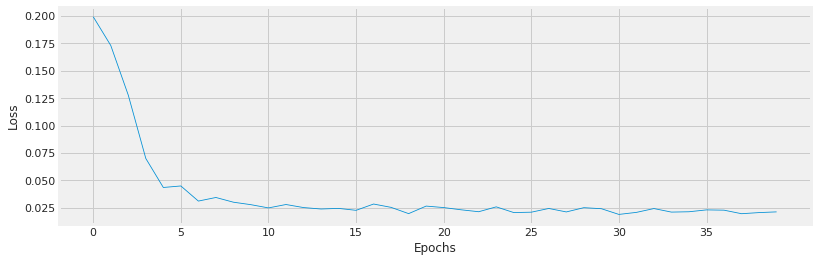

In [643]:
filepath='../gdrive/My Drive/Colab Notebooks/EU_electricity/weights-LSTM1_24-{loss:.3f}.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=True, mode='auto', monitor="loss")
callbacks_list = [cp_callback]

n_inputs = 1
n_timesteps = scaled_train_24.shape[1]
epochs = 40
prediction_window = 24

lstm_model1_24 = Sequential()
lstm_model1_24.add(LSTM(150, activation='relu', input_shape=(n_timesteps, n_inputs)))
lstm_model1_24.add(Dropout(0.3))
lstm_model1_24.add(Dense(prediction_window))
lstm_model1_24.compile(optimizer='adam', loss='mse')

lstm_model1_24.fit(X_train_24, y_train_24, steps_per_epoch=5, epochs=epochs, verbose=1, callbacks=callbacks_list)

training_perf(lstm_model1_24)

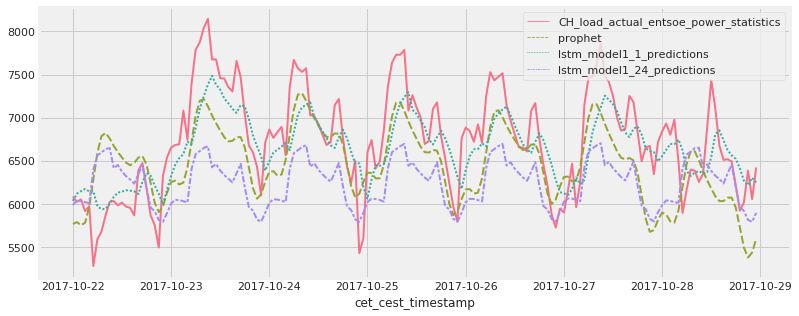

In [644]:
# Make a transformation on test data, predict and visualise the result.

scaled_month = scaler.transform(month)

prediction_input = 24
n_of_days = int(len(test)/prediction_input)

lstm_model1_24_predictions_scaled = []

for i in range(0,n_of_days):

  test_slice = np.array(scaled_month[480+i:671][:prediction_input])
  test_slice = test_slice.reshape((1,24,1))
  lstm_pred = lstm_model1_24.predict(test_slice)
  lstm_model1_24_predictions_scaled.append(lstm_pred[0])

lstm_model1_24_predictions = scaler.inverse_transform(lstm_model1_24_predictions_scaled)

# Write prediction output in 24h steps.
pd.set_option('mode.chained_assignment', None)
test["lstm_model1_24_predictions"] = 0
for number, i in enumerate(range(0,len(test),24)):
  test["lstm_model1_24_predictions"][i:24+i] = lstm_model1_24_predictions[number]

plt.figure(figsize = (12,5))
sns.lineplot(data=test, palette="husl", lw=2)

For this task, algorithm applies the same pattern for every day, not taking into consideration differences between days.

Because the way this model is trained, it only sees 21 example. Would the result get better with much more data?

### LSTM with more training data

Training on 1 year data and making predictions for the same period as above.

In [0]:
# First - scale the training data

training = ch_df[(ch_df.index.year == 2016)]
training = training[['CH_load_actual_entsoe_power_statistics']]

scaler_year = MinMaxScaler()
scaler_year.fit(training)
scaled_train = scaler_year.transform(training)


In [646]:
int(scaled_train.shape[0]/24)

366

In [0]:
scaled_train_366 = scaled_train.reshape(int(scaled_train.shape[0]/24),24,1)

X_train_366, y_train_366  = scaled_train_366[:-1], scaled_train_366[1:]

In [648]:
X_train_366.shape

(365, 24, 1)

Train on 328 samples, validate on 37 samples
Epoch 1/60
246/328 [=====================>........] - ETA: 0s - loss: 0.2265
Epoch 00001: loss improved from inf to 0.22794, saving model to ../gdrive/My Drive/Colab Notebooks/EU_electricity/weights-LSTM1_24-0.228.hdf5
328/328 [==============================] - 2s 6ms/sample - loss: 0.2279 - val_loss: 0.3012
Epoch 2/60
246/328 [=====================>........] - ETA: 0s - loss: 0.2131
Epoch 00002: loss improved from 0.22794 to 0.20596, saving model to ../gdrive/My Drive/Colab Notebooks/EU_electricity/weights-LSTM1_24-0.206.hdf5
328/328 [==============================] - 1s 2ms/sample - loss: 0.2060 - val_loss: 0.2652
Epoch 3/60
246/328 [=====================>........] - ETA: 0s - loss: 0.1798
Epoch 00003: loss improved from 0.20596 to 0.17451, saving model to ../gdrive/My Drive/Colab Notebooks/EU_electricity/weights-LSTM1_24-0.175.hdf5
328/328 [==============================] - 1s 2ms/sample - loss: 0.1745 - val_loss: 0.2048
Epoch 4/60
246/32

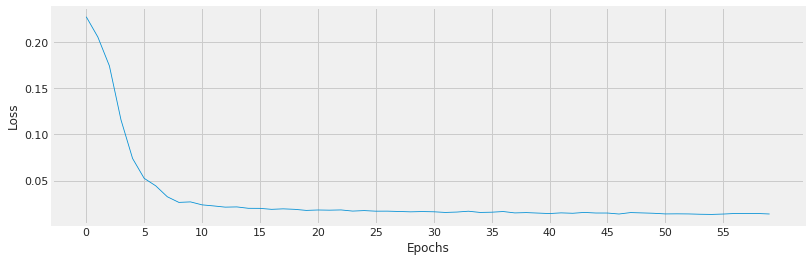

In [649]:
filepath='../gdrive/My Drive/Colab Notebooks/EU_electricity/weights-LSTM1_24-{loss:.3f}.hdf5'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_best_only=True, mode='auto', monitor="loss")
callbacks_list = [cp_callback]

n_inputs = 1
n_timesteps = scaled_train_366.shape[1]
epochs = 60
prediction_window = 24

lstm_model1_366 = Sequential()
lstm_model1_366.add(LSTM(150, activation='relu', input_shape=(n_timesteps, n_inputs)))
lstm_model1_366.add(Dropout(0.3))
lstm_model1_366.add(Dense(prediction_window))
lstm_model1_366.compile(optimizer='adam', loss='mse')

lstm_model1_366.fit(X_train_366, y_train_366, steps_per_epoch=4, epochs=epochs, verbose=1, callbacks=callbacks_list, validation_split=0.1)

training_perf(lstm_model1_366)

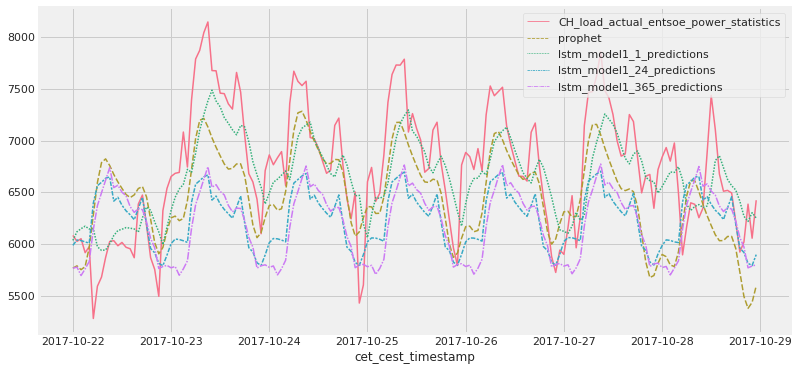

In [650]:
scaled_month = scaler_year.transform(month)

prediction_input = 24
n_of_days = int(len(test)/prediction_input)

lstm_model1_365_predictions_scaled = []

for i in range(0,n_of_days):

  test_slice = np.array(scaled_month[480+i:671][:prediction_input])
  test_slice = test_slice.reshape((1,24,1))
  lstm_pred = lstm_model1_366.predict(test_slice)
  lstm_model1_365_predictions_scaled.append(lstm_pred[0])

lstm_model1_365_predictions = scaler_year.inverse_transform(lstm_model1_365_predictions_scaled)

# Write prediction output to every 24th row
pd.set_option('mode.chained_assignment', None)
test["lstm_model1_365_predictions"] = 0
for number, i in enumerate(range(0,len(test),24)):
  test["lstm_model1_365_predictions"][i:24+i] = lstm_model1_365_predictions[number]

plt.figure(figsize = (12,6))
sns.lineplot(data=test, palette="husl", lw=1.5)

Very similar pattern to previous one is observed here too.



# Calculating RMSE to compare algorithms performance with official, Day-ahead Total Load Forecast.

In [0]:
test['CH_load_forecast_entsoe_transparency'] = ch_df[['CH_load_forecast_entsoe_transparency']]

In [652]:
test.head()

CH_load_actual_entsoe_power_statistics  ...  CH_load_forecast_entsoe_transparency
cet_cest_timestamp                                           ...                                      
2017-10-22 00:00:00                                  6083.0  ...                               6257.91
2017-10-22 01:00:00                                  6025.0  ...                               6204.05
2017-10-22 02:00:00                                  6051.0  ...                               5862.37
2017-10-22 03:00:00                                  5916.0  ...                               5708.19
2017-10-22 04:00:00                                  5974.0  ...                               5661.95

[5 rows x 6 columns]

In [653]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print('Official forecast error {}'.format(sqrt(mean_squared_error(test.CH_load_actual_entsoe_power_statistics.values, test.CH_load_forecast_entsoe_transparency))))
print('Prophet error {}'.format(sqrt(mean_squared_error(test.CH_load_actual_entsoe_power_statistics.values, test.prophet))))
print('LSTM 1h prediction {}'.format(sqrt(mean_squared_error(test.CH_load_actual_entsoe_power_statistics.values, test.lstm_model1_1_predictions))))
print('LSTM 24h prediction, with 21 training days {}'.format(sqrt(mean_squared_error(test.CH_load_actual_entsoe_power_statistics.values, test.lstm_model1_24_predictions))))
print('LSTM 24h prediction, with 365 training days {}'.format(sqrt(mean_squared_error(test.CH_load_actual_entsoe_power_statistics.values, test.lstm_model1_365_predictions))))


Official forecast error 746.2775149370342
Prophet error 529.7927936307491
LSTM 1h prediction 393.3255265576651
LSTM 24h prediction, with 21 training days 697.6833897238841
LSTM 24h prediction, with 365 training days 752.9116020353871


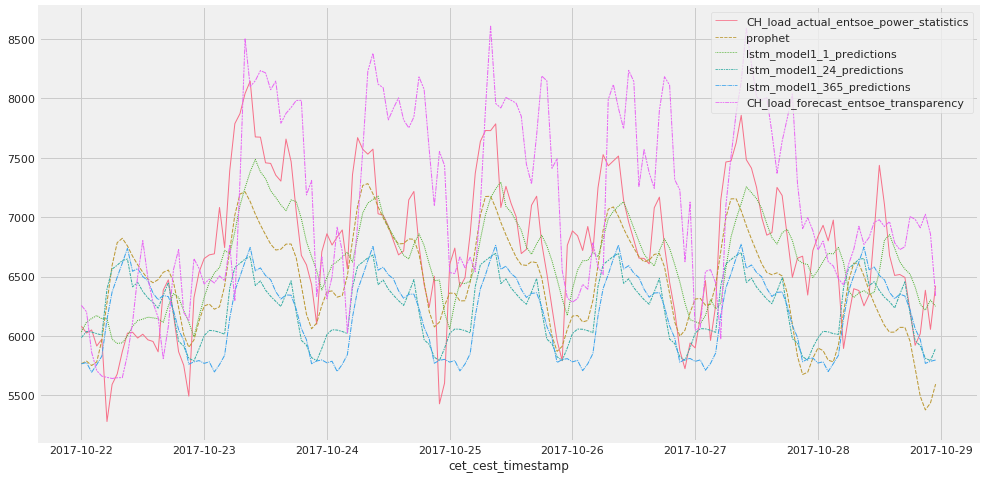

In [654]:

plt.figure(figsize = (15,8))
sns.lineplot(data=test, palette="husl", lw=1)

# Conclusions

Interesting to see that depending on a month, either Prophet or LSTM model1_24 outperforms official forecast. That is pretty impressive performance knowing that there are no additional data being used (like weather forecast) to make more accurate predictions.